In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import speckle_stuffs as spkstf
import pickle
import scipy
import os
import pandas as pd
import seaborn as sns
sns.set()


In [20]:
# take 1 px binning for display purposes
rootff = ''
picklesource = rootff+'/data_25012019_002_39519608500622_762875588588056.pickle' # fig 2

filehandler = open(picklesource, 'rb')
[extr_traces, extr_footprints, dpars] = pickle.load(filehandler)
filehandler.close()
videofile = rootff+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'.mat'
video_source = np.swapaxes(scipy.io.loadmat(videofile)['video_data'], 0, 2)
gtfile = rootff+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'_gt.mat'
grtrh_traces = scipy.io.loadmat(gtfile)['pat']
grtrh_footprints = video_source[:dpars['components']]
grtrh_footprintsf =  spkstf.gauss_don_filt_GPU(grtrh_footprints, lp=dpars['lowfilter'], hp=dpars['highfilter'])

cannot import cuda libraries, filtering with the CPU...


In [5]:
inde = 14

lp = dpars['lowfilter']
hp = dpars['highfilter']

cut_vs = video_source[-500:]
contrasts = np.array([spkstf.contrast(frame) for frame in cut_vs])
mn = np.mean(contrasts)
sd = np.std(contrasts)

idxs = [29, 499]


fig = plt.figure(figsize=(15, 5*len(idxs)))

for i, idx in enumerate(idxs):
    ax = fig.add_subplot(len(idxs),3,1+i*3)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx])
  
    ax.grid(False)
    if i==0: ax.set_title('Raw image')
    if i!=(len(idxs)-1): 
        ax.set_xticks([])
        ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

    ax = fig.add_subplot(len(idxs),3,2+i*3)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], lp=lp)
    ax.grid(False)
    if i==0: ax.set_title('Noise filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

    ax = fig.add_subplot(len(idxs),3,3+i*3)
    frame = spkstf.gauss_don_filt_GPU(cut_vs[idx], hp=hp, lp=lp)
        
    ax.grid(False)
    if i==0: ax.set_title('Noise and envelope filtered')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(frame, cmap='gray')

fig.tight_layout()
fig.show()

cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
cannot import cuda libraries, filtering with the CPU...
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [22]:
filehandler = open(picklesource, 'rb')
[extr_traces, extr_footprints, dpars] = pickle.load(filehandler)
filehandler.close()

videofile = rootff+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'.mat'
print(videofile)
video_source = spkstf.extract_from_mat(videofile, 'video_data')
gtfile = rootff+picklesource.split('/')[-1].split('_')[1] + os.sep+ '_'.join((picklesource.split('/')[-1]).split('_')[:3])+'_gt.mat'
grtrh_traces = scipy.io.loadmat(gtfile)['pat']

grtrh_footprints = video_source[:dpars['components']]
grtrh_footprints =  spkstf.gauss_don_filt_GPU(grtrh_footprints, lp=dpars['lowfilter'], hp=dpars['highfilter'])

grtrh_footprints = spkstf.bin_video(grtrh_footprints, dpars['binning'])

traces_cc, footprints_cc = spkstf.build_cc_mtrxs(grtrh_traces, extr_traces, grtrh_footprints, extr_footprints,  
                                                 method='zncc', halfmatrix=False)

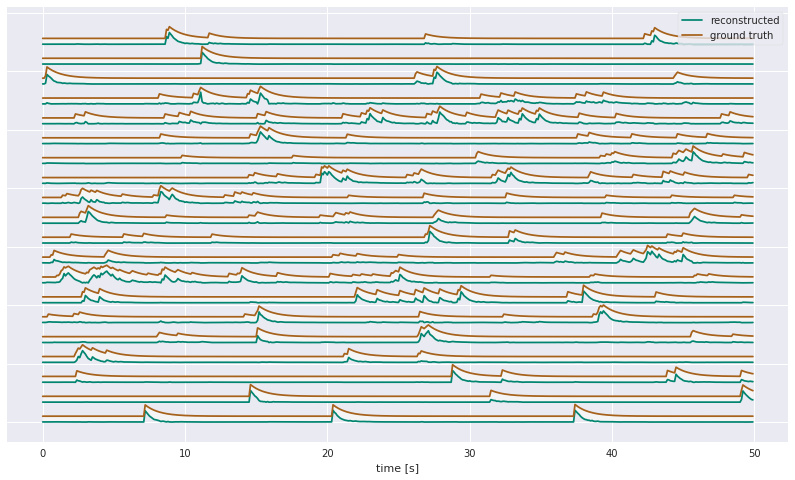

In [238]:
sns.set()


def nnl(trace):
    return (trace-np.min(trace))/(np.max(trace)-np.min(trace))

def plot_nicely_traces(ax3):
    shift = 0
    xxx = np.arange(np.shape(grtrh_traces)[1])*0.1
    extrace = -1
    for [idx, extridx, _] in couplings:
        idx = int(idx)
        extridx = int(extridx)
        gtt = nnl(grtrh_traces[idx])
        ext = nnl(extr_traces[extridx])
        ax3.plot(xxx, ext+shift, '-', c='#018571', alpha=1, label='ground truth')
        oshift = shift
        shift += (np.max(gtt)-np.min(gtt))/2
        ax3.fill_between(xxx, ext+oshift, gtt+shift, color='#f5f5f5', alpha=1)
        ax3.plot(xxx, gtt+shift, c='#a6611a', alpha=1, label='reconstructed')
        extrace = gtt+shift
        shift += (np.max(ext)-np.min(ext))*1.2
    ax3.tick_params(labelleft=False)
    ax3.set_xlabel('time [s]')
    
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
plot_nicely_traces(ax)
ax.legend(('reconstructed', 'ground truth'), frameon=True)
fig.savefig(rootff+'fig2t.eps', dpi=300)
fig.show()